# Order book visualization

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
from decimal import Decimal
from alex.database import Database # вспомогательный класс для подключения к базе и работе с sql
%matplotlib inline

In [45]:
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('csv')

DataTransformerRegistry.enable('csv')

In [3]:
# чтобы посмотреть содержимое файла database.py, из которого импортируется Database, раскомментируй следующую строку:
#%load alex/database/database.py

In [4]:
db = Database() # подключение к базе данных с учётными данными для Alex

In [5]:
def optimize_df(df):
    # оптимизация размера датафрейма - преобразование в категории того, чего надо 
    # и присвоение типа Decimal фин.показателям
    for col in df.columns:
        if col in ('exchange', 'pair', 'bid_ask'):
            df[col] = df[col].astype('category')
        if col in ('price', 'amount', 'volume'):
            df[col] = df[col].astype(Decimal)
    return df

In [6]:
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

## Most recent Order book

In [33]:
exchange = "binance"
pair = "ETH/USDT"
lag_minutes = 10

In [34]:
#sql_orderbook = f"select * from v_order_book with (snapshot) where exchange='{exchange}' and pair='{pair}'"
sql_orderbook = f"select * from tvf_get_order_book_snapshots({lag_minutes}) where exchange='{exchange}' and pair='{pair}' order by dt"
df_orderbook = optimize_df(db.query(sql_orderbook))

df_orderbook['price_0d'] = [round(x, 0) for x in df_orderbook['price']] # округление до 1 знаков после запятой
df_orderbook['price_1d'] = [round(x, 1) for x in df_orderbook['price']] # округление до 1 знаков после запятой
df_orderbook['price_2d'] = [round(x, 2) for x in df_orderbook['price']] # округление до 2 знаков после запятой

In [23]:
bids = df_orderbook[df_orderbook.bid_ask=='bid']
asks = df_orderbook[df_orderbook.bid_ask=='ask']

lob = df_orderbook.groupby(['price_2d', 'bid_ask']).agg({'amount':sum, 'volume':sum}).reset_index()
#bids_lob = bids.groupby(['price_1d']).agg({'amount':sum}).reset_index()
#asks_lob = asks.groupby(['price_1d']).agg({'amount':sum}).reset_index()
#bids.head().append(asks.head())

In [24]:
prices = np.array(lob['price_2d'])

In [25]:
rejected = reject_outliers(prices, m=4)

In [26]:
rejected.shape

(524,)

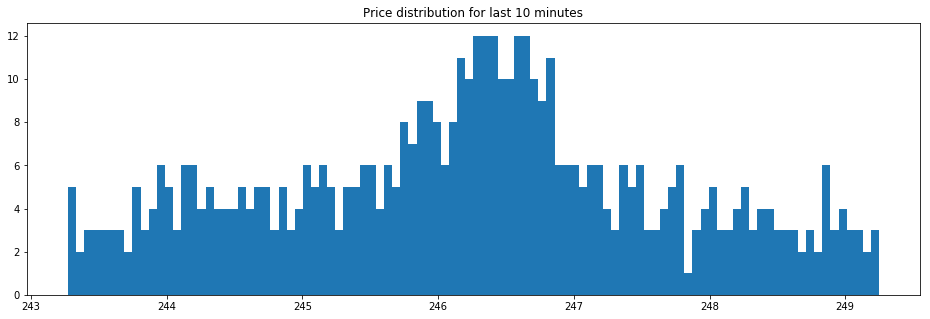

In [38]:
plt.hist(prices, bins=100)
plt.title(f"Price distribution for last {lag_minutes} minutes")
plt.rcParams['figure.figsize'] = [16, 5]
plt.show()

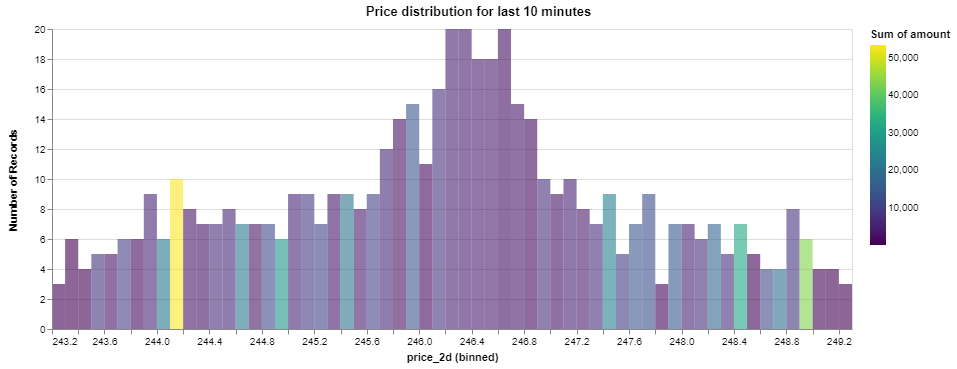

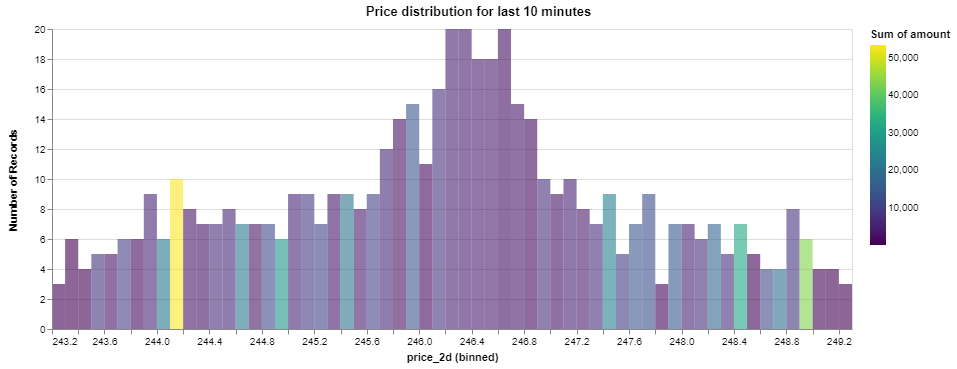

In [55]:
chart = alt.Chart(lob).mark_rect().encode(
    alt.X("price_2d", bin=alt.Bin(maxbins=100)),
    y="count(amount)",
    color="sum(amount)"
).properties(
    title=f"Price distribution for last {lag_minutes} minutes",
    width=800
).configure_mark(
    opacity=0.6
)
chart

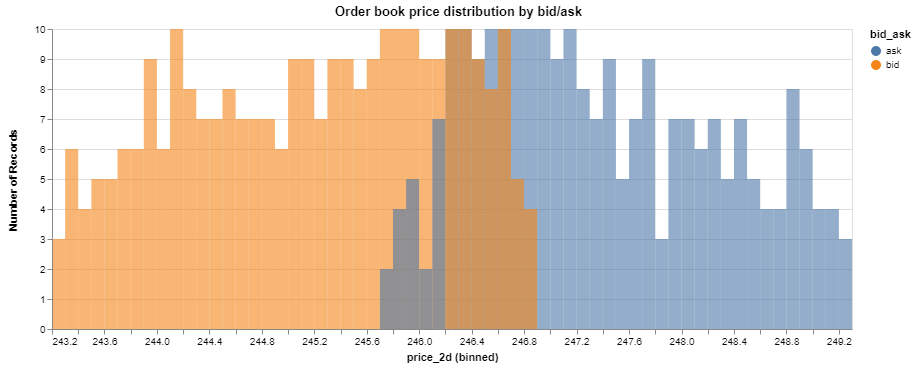

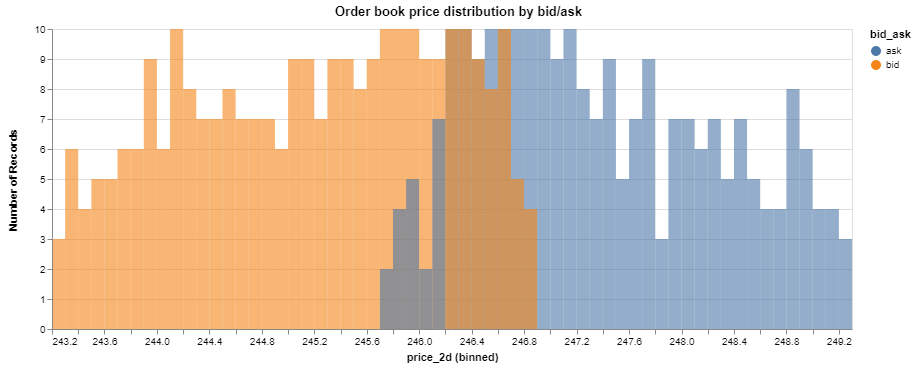

In [56]:
chart = alt.Chart(lob).mark_rect().encode(
    alt.X("price_2d", bin=alt.Bin(maxbins=100)),
    y="count(amount)",
    color="bid_ask"
).properties(
    title="Order book price distribution by bid/ask",
    width=800
).configure_mark(
    opacity=0.6
)
chart

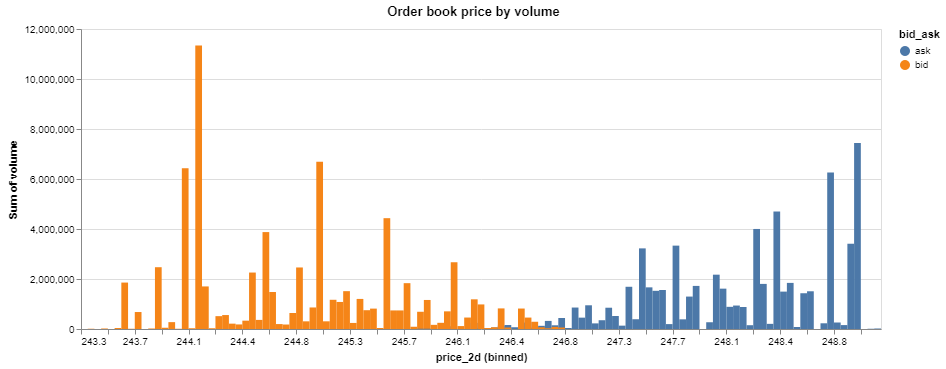

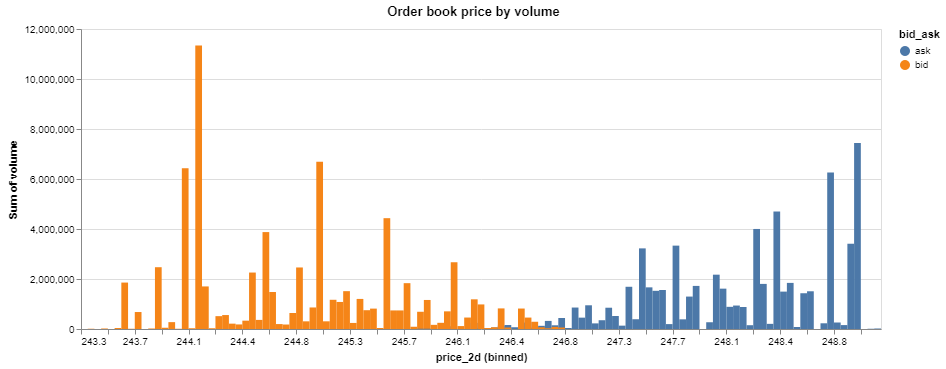

In [42]:
chart = alt.Chart(lob).mark_rect().encode(
    #x="price_1d",
    #alt.X("price_1d"),
    alt.X("price_2d", bin=alt.Bin(maxbins=200)),
    #y="amount",
    y="sum(volume)",
    color="bid_ask"
).properties(
    title="Order book price by volume",
    width=800
)
chart#.interactive()

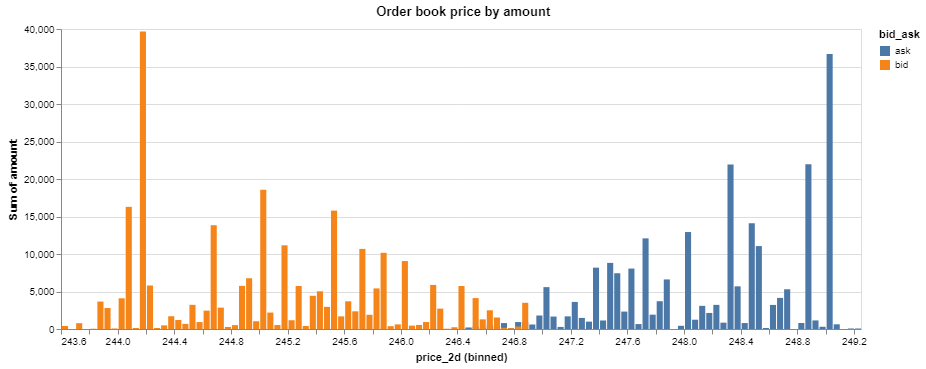

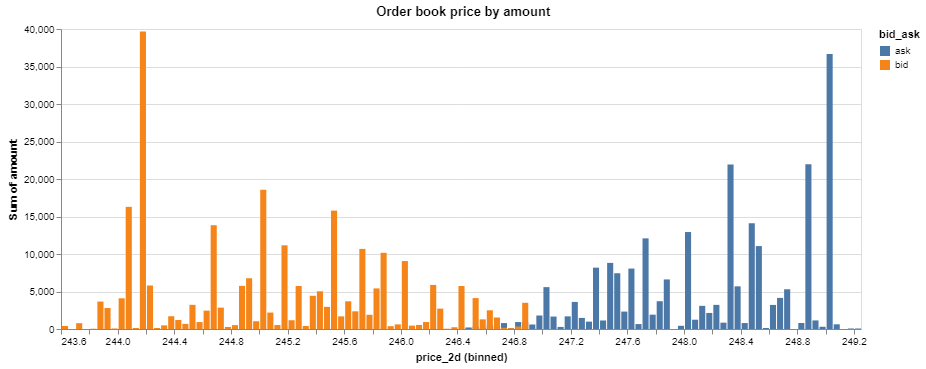

In [46]:
#brush = alt.selection(type="interval")
chart = alt.Chart(df_orderbook).mark_bar().encode(
    #x="price_1d",
    #alt.X("price_1d"),
    alt.X("price_2d", bin=alt.Bin(maxbins=200)),
    #y="amount",
    alt.Y("sum(amount)", stack=None),
    color="bid_ask"
).properties(
    title="Order book price by amount",
    width=800
)
#chart.config = {'view': {'height': 400, 'width': 800}}
chart#.interactive()

In [ ]:
plt.rcParams['figure.figsize'] = [17, 4]
plt.grid(b=True, which='major', color='lightgray', linestyle='-')
#plt.xticks(minor=True)
plt.minorticks_on()
#plt.grid(which='minor', color='gray', linestyle='--')
plt.hist([price_bid, price_ask], bins=50)
plt.legend(["bids", "asks"])
plt.title("Bids/Asks 4-decimals precision")
plt.show()

In [ ]:
# rounding
price_bid = [round(x, 1) for x in bid_prices]
price_ask = [round(x, 1) for x in ask_prices]

In [ ]:
plt.rcParams['figure.figsize'] = [17, 4]
plt.grid()
plt.hist([price_bid, price_ask], bins=50)
plt.legend(["bids", "asks"])
plt.title("Bids/Asks 1-decimal precision")
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.pie([sum(amount_bid), sum(amount_ask)])
plt.legend(["bids", "asks"])
plt.title("Bids/Asks by Amount")
plt.show()

## Order book at particular date

In [ ]:
date = '2018-09-20 0:00:00'
exchange = "binance"
pair = "ETH/USDT"
sql = f"select * from dbo.tvf_get_order_book_at_date('{date}') where exchange='{exchange}' and pair='{pair}'"
df_at_date = optimize_df(db.query(sql))

In [ ]:
df_at_date.sort_values('dt', ascending=False).head()

## Order book snapshots for last N minutes

In [ ]:
minutes = 120 # кол-во минут назад от текущего момента
exchange = "binance"
pair = "ETH/USDT"
sql = f"select * from tvf_get_order_book_snapshots({minutes}) where exchange='{exchange}' and pair='{pair}'"
df_orderbook_snapshots = optimize_df(db.query(sql))

In [ ]:
df_orderbook_snapshots.info()

## History

In [ ]:
date = '2018-09-20 0:00:00' # дата с которой загружать историю
sql_history = f"select * from v_history with (snapshot) where exchange='{exchange}' and pair='{pair}' " \
              f"and dt>='{date}'"

In [ ]:
df_history = optimize_df(db.query(sql_history))

In [ ]:
df_history.set_index('dt', inplace=True)

In [ ]:
df_history.head()